In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 71.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 76.3 MB/s eta 0:00:00


In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm


import json

In [3]:
import json
file = open('arxivData.json')
data = json.load(file)

In [4]:
def trl(container):
    return tqdm(range(len(container)))

def prepared(string):
    string = string.replace("'", '"')
    string = string.replace('None', 'null')
    return string

In [5]:
titles = [data[i]['title'] for i in trl(data)]
summaries = [data[i]['summary'] for i in trl(data)]
tags = [[json.loads(prepared(data[i]['tag']))[j]['term'] for j in range(len(json.loads(prepared(data[i]['tag']))))] for i in trl(data)]

  0%|          | 0/41000 [00:00<?, ?it/s]

  0%|          | 0/41000 [00:00<?, ?it/s]

  0%|          | 0/41000 [00:00<?, ?it/s]

In [6]:
tags[200:210]

[['cs.LG', 'cs.AI', 'cs.CV', 'cs.NE'],
 ['cs.CV', 'cs.AI', 'cs.LG', 'cs.NE', '68T05, 68T45', 'I.2.6; I.4.6; I.5.5'],
 ['cs.LG', 'cs.AI', 'cs.CV', 'cs.NE'],
 ['cs.LG', 'cs.AI', 'cs.CV', 'cs.NE'],
 ['cs.LG', 'cs.CV', 'cs.NE', 'stat.ML'],
 ['stat.ML', 'cs.CV', 'cs.LG', 'cs.NE'],
 ['stat.ML', 'cs.CV', 'cs.LG', 'cs.NE'],
 ['cs.CV', 'cs.LG', 'cs.NE', 'stat.ML'],
 ['stat.ML', 'cs.CV', 'cs.LG', 'cs.NE'],
 ['cs.NE', 'cs.CV', 'cs.LG', 'stat.ML']]

## Какие вообще есть классы и сколько их эту инфу хочется сохранить и загружать потом

In [7]:
import requests
page = requests.get("https://arxiv.org/category_taxonomy")

In [9]:
from bs4 import BeautifulSoup
soup = BeautifulSoup(page.content, 'html.parser')

In [10]:
h4_cases = soup.find_all('h4')

In [11]:
tags_tags = h4_cases[1:]
possible_tags = set()
tag_to_id = {}
id_to_tag = {}
id_to_description = {}
for i, html_tag in enumerate(tags_tags):
    idx = html_tag.get_text().find(' ')
    tag = html_tag.get_text()[:idx]
    description = html_tag.get_text()[idx+2:-1]
    possible_tags.add(tag)
    tag_to_id[tag] = i
    id_to_tag[i] = tag
    id_to_description[i] = description

In [12]:
num_tags = len(possible_tags)

In [11]:
len(possible_tags)

155

In [13]:
with open('tags.txt', 'w') as file:
    for i in range(num_tags):
        file.write(str(id_to_tag[i]) + ' ' + str(id_to_description[i]) + '\n')

In [14]:
for i, line in enumerate(tags):
    line = list(set(line) & possible_tags)
    int_line = []
    for tag in line:
        int_line.append(tag_to_id[tag])
    tags[i] = int_line

In [14]:
#data = pd.read_json("arxivData.json")
#data

In [15]:
#data[["tag"]]

In [16]:
#len(data)

In [17]:
#x = data[["summary", "title"]]
#(np.array(x)).shape

In [18]:
#x = x["summary"].values

In [19]:
#x = list(x)

In [20]:
#data["tag"]

In [21]:
#import ast

In [22]:
#tags = (data["tag"]).apply(ast.literal_eval)

#y = [[tags[row][tag_index]['term'] for tag_index in range(len(tags[row]))] for row in range(len(tags))]


In [23]:
#[len(y[row]) for row in range(len(y))]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

In [25]:
## кол-во различных тем
#kkk_ans = []
#dd = [[kkk_ans.append(prepared(tags[row][tag_index]['term'])) for tag_index in range(len(tags[row]))] for row in range(len(tags))]
#set(kkk_ans)

## Разделение данных на train test и подготовка батчей

In [20]:
from sklearn.model_selection import train_test_split

titles_train, titles_test, summaries_train, summaries_test, tags_train, tags_test = train_test_split(titles, summaries, tags, test_size=0.1, random_state=42)

In [21]:
from transformers import AutoTokenizer, AutoModel, pipeline, DistilBertForSequenceClassification

base_model_name = 'distilbert-base-uncased'
base_tokenizer = AutoTokenizer.from_pretrained(base_model_name)
#base_model = AutoModel.from_pretrained(base_model_name).to('cuda')

In [22]:
def multi_hot(indexes, num_classes):
    return torch.zeros((num_classes,)).scatter_(0, torch.tensor(indexes), torch.ones((num_classes,)))

In [23]:
from torch.utils.data import Dataset, DataLoader

class ArXivDataset(Dataset):
    def __init__(self, titles, abstracts, tags, possible_tags, tokenizer):
        super(ArXivDataset, self).__init__()
        self. titles = titles
        self.abstracts = abstracts
        self.tags = tags
        self.possible_tags = possible_tags
        self.num_classes = len(self.possible_tags)
        self.tokenizer = tokenizer
        
        self.inputs = ['Title: ' + self.titles[idx] + ' Abstract: ' + self.abstracts[idx] for idx in range(len(titles))]
        self.inputs = self.tokenizer(self.inputs, truncation=True, padding='max_length', max_length=512, return_tensors='pt')['input_ids']
    
    def __len__(self):
        return len(self.titles)
    
    def __getitem__(self, idx):
        return (self.inputs[idx], multi_hot(self.tags[idx], self.num_classes) / len(self.tags[idx]))

In [24]:
base_train_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, base_tokenizer)
base_test_ds = ArXivDataset(titles_test, summaries_test, tags_test, possible_tags, base_tokenizer)

base_train_dl = DataLoader(base_train_ds, shuffle=True, 
    batch_size=128, num_workers=0)
base_test_dl = DataLoader(base_test_ds, shuffle=True, 
    batch_size=128, num_workers=0)

small_ds = ArXivDataset(titles_train, summaries_train, tags_train, possible_tags, base_tokenizer)
small_dl = DataLoader(small_ds, shuffle=True, 
    batch_size=128, num_workers=0)

## Токенизация

In [29]:
#tokens_info = tokenizer(x, padding=True, truncation=True, return_tensors="pt")

In [30]:
#print(tokens_info)

In [31]:
#for i in range(2):
#    print(tokenizer.decode(tokens_info['input_ids'][i]))
# тестик того что выведет

## Модель классификации

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

In [34]:
#tokens_info['input_ids'].shape

In [35]:

## тестики
# #for param in model.parameters():
# #    param.requires_grad = False
    
# ## !!!
# final_model = nn.Sequential(
#     tokenizer,
#     model
# )
# ####

# for param in final_model.parameters():
#     param.requires_grad = False

# final_model.second.classifier = nn.Sequential(
#     torch.nn.Linear(20, 30),
# )

# model

# model.classifier = torch.nn.Identity()

# with torch.no_grad():
#     kk= tokens_info['input_ids'][:2]
#     ans = model(tokens_info['input_ids'][:2])

# ans.logits.shape

#DataLoader(data, batch_size=batch_size, shuffle=(num_samples is None))

In [36]:
# for epoch in range(100):
#     gd.zero_grad()
#     loss = batch_loss(batch)
#     if maximization:
#         (-loss).backward()
#     else:
#         loss.backward()
#     gd.step()

## Проедура для обучения, валидации и отрисовки графиков(взять из прошлой дз)

In [25]:
import matplotlib.pyplot as plt

def plot_learning_process(train_loss, val_loss):    
    plt.figure()
    plt.title('loss by epoch')
    plt.plot(np.arange(0, len(val_loss))+0.5, train_loss, label='train')
    plt.plot(np.arange(0, len(val_loss))+1, val_loss, label='val')
    plt.legend()
    plt.grid()
    plt.xlabel('epoch')
    plt.ylabel('loss function')
    plt.show()
    

In [26]:
#!g1.1

device = 'cuda'

import IPython
from math import ceil


def train_loop(model, dataloader, loss_fn, optimizer, step=0.05, history_loss=None):
    out = display(IPython.display.Pretty('Learning...'), display_id=True)
    
    size = len(dataloader.dataset) 
    len_size = len(str(size))
    batches = ceil(size / dataloader.batch_size) - 1
        
    train_loss = []
    percentage = 0
    for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc="Batch #")):
        X, y = X.to(device), y.to(device)
        # evaluate
        output = F.softmax(model(X).logits, dim=1)
        loss = loss_fn(output, y)
        train_loss.append(loss.item())
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print info
        if batch / batches > percentage or batch == batches: 
            out.update(f'[{int(percentage * size)}/{size}] Loss: {train_loss[-1]:>8f}')
            percentage += step
        
    if history_loss is not None:
        history_loss.append(np.mean(train_loss))

    return {'train_loss': np.mean(train_loss)}
        
def test_loop(model, dataloader, loss_fn, history_loss=None, history_acc=None):

    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    batches = ceil(size / dataloader.batch_size)

    val_loss = []
    
    with torch.no_grad():
        # evalute and check predictions
        for batch, (X, y) in enumerate(tqdm(dataloader, leave=False, desc='Batch #')):
            X, y = X.to(device), y.to(device)
            output = F.softmax(model(X).logits, dim=1)
            loss = loss_fn(output, y)
            test_loss += loss.item()
                
            val_loss.append(loss.item())
            
    test_loss /= batches
    correct /= size
    
    print(f"Validation accuracy: {(100*correct):>0.1f}%, Validation loss: {test_loss:>8f} \n")
    
    if history_loss is not None:
        history_loss.append(np.mean(val_loss))
    
    return {'val_loss': np.mean(val_loss)}

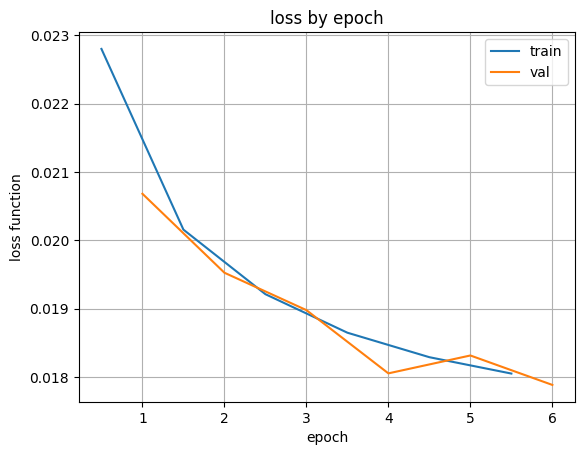

In [29]:
#!g1.1
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output

classifier = DistilBertForSequenceClassification.from_pretrained(base_model_name, num_labels=num_tags).to('cuda')
for param in classifier.base_model.parameters():
    param.requires_grad = False

classifier.train()
loss_fn = F.binary_cross_entropy
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
epochs = 6

train_loss = []
val_loss = []
    
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    train_loop(classifier, base_train_dl, loss_fn, optimizer, history_loss=train_loss)
    test_loop(classifier, base_test_dl, loss_fn, history_loss=val_loss)
    
    clear_output()
    plot_learning_process(train_loss, val_loss)

In [30]:
torch.save(classifier.state_dict(), './weight_model')

In [31]:
classifier.save_pretrained('./models')

In [40]:
#!unzip arxiv-metadata-oai-snapshot.json

In [41]:
# big_data = []
# with open('arxiv-metadata-oai-snapshot.json') as big_file:
#     for line in tqdm(big_file):
#         big_data.append(json.loads(line))
#         if len(big_data) >= 10**5:
#             break

In [42]:
# titles = [big_data[i]['title'] for i in trl(big_data)]
# summaries = [big_data[i]['abstract'] for i in trl(big_data)]
# tags = [big_data[i]['categories'].split() for i in trl(big_data)]

In [43]:
# for i, line in enumerate(tags):
#     line = list(set(line) & possible_tags)
#     int_line = []
#     for tag in line:
#         int_line.append(tag_to_id[tag])
#     if len(int_line) == 0:
#         int_line.append(155)
#     tags[i] = int_line

## Обучение модельки

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bia

RuntimeError: ignored

какой должен быть пайплайн на сервере: я беру данные склеиваю их + предобученныЙ токенайзер(я не буду загружать для него специальный файл т к я никак его не дообучаю) + кладу его в свою модель 

In [ ]:
x = torch.tensor([1, 2])

In [ ]:
x = x.to('cuda')

In [ ]:
x